In [1]:
import numpy as np
import pandas as pd

Q1

In [2]:
problem01_data= pd.read_csv("problem1.csv")
problem01_data.describe()
problem01_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


In [3]:
problem01_data.head(5)

,X
0,-0.118037
1,0.149343
2,-0.083849
3,-0.025407
4,0.119084


In [4]:
from scipy.stats import skew, kurtosis
mean = problem01_data['X'].mean()
variance = problem01_data['X'].var()
skewness = skew(problem01_data['X'])
kurt = kurtosis(problem01_data['X'])

print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

Mean: 0.05019795790476916
Variance: 0.010332476407479581
Skewness: 0.1204447119194402
Kurtosis: 0.2229270674503816


In [5]:
from scipy.stats import norm, t


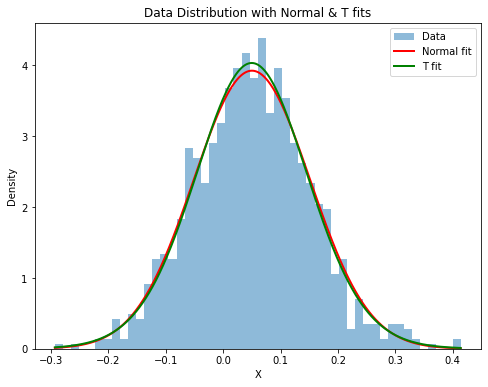

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

X_value = problem01_data['X']
mu_norm, sigma_norm = norm.fit(X_value)
df_t, loc_t, scale_t = t.fit(X_value)


x = np.linspace(min(X_value), max(X_value), 1000)
pdf_norm = norm.pdf(x, loc=mu_norm, scale=sigma_norm)
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

plt.figure(figsize=(8, 6))
plt.hist(X_value, bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_norm, 'r-', linewidth=2, label='Normal fit')
plt.plot(x, pdf_t, 'g-', linewidth=2, label='T fit')
plt.title("Data Distribution with Normal & T fits")
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.show()

In [7]:
# compute the total log-likelihood of the data under each fitted distribution by summing the log of the PDF values.
log_likelihood_norm = np.sum(norm.logpdf(X_value, loc=mu_norm, scale=sigma_norm))
log_likelihood_t = np.sum(t.logpdf(X_value, df_t, loc=loc_t, scale=scale_t))

# Calculating the AICc value of normal and t distribution respectively
k_norm = 2
AIC_norm = 2 * k_norm - 2 * log_likelihood_norm

k_t = 3
AIC_t = 2 * k_t - 2 * log_likelihood_t

print("Normal Distribution AIC:", AIC_norm)
print("T Distribution AIC:", AIC_t)

Normal Distribution AIC: -1731.586728836508
T Distribution AIC: -1731.4183689195443


Q2

In [8]:
problem02_data= pd.read_csv("problem2.csv")

In [9]:
cov_matrix111 = problem02_data.cov()
cov_matrix111

,x1,x2,x3,x4,x5
x1,1.470484,1.454214,0.877269,1.903226,1.444361
x2,1.454214,1.252078,0.539548,1.621918,1.237877
x3,0.877269,0.539548,1.272425,1.171959,1.091912
x4,1.903226,1.621918,1.171959,1.814469,1.589729
x5,1.444361,1.237877,1.091912,1.589729,1.396186


In [10]:
from scipy.linalg import eigh
from numpy.linalg import cholesky

def is_positive_semidefinite(cov_matrix,tolerance=1e-8):
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    print(eigenvalues)   
    for i in range(len(eigenvalues)):
        if eigenvalues[i] >=tolerance:
            continue
        else:
            print(f"covariance matrix is not  at least positive semi-definite, {eigenvalues[i]}")
is_positive_semidefinite(cov_matrix111)


[-0.31024286 -0.13323183  0.02797828  0.83443367  6.78670573]
covariance matrix is not  at least positive semi-definite, -0.31024286045858984
covariance matrix is not  at least positive semi-definite, -0.13323183214860962


In [11]:
def Higham(covariance_df, max_iterations=100, tolerance=1e-8):
    def project_to_psd(matrix):
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        eigenvalues = np.maximum(eigenvalues, 0)
        return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    def project_to_unit_diagonal(matrix):
        projected_matrix = matrix.copy()
        np.fill_diagonal(projected_matrix, 1)
        return projected_matrix

    def matrix_infinity_norm(matrix):
        return np.max(np.abs(matrix).sum(axis=1))

    def compute_nearest_correlation(matrix, max_iterations=100, tolerance=1e-8):
        prev_Y, prev_X, delta_S = matrix.copy(), matrix.copy(), np.zeros_like(matrix)
        for _ in range(max_iterations):
            residual = prev_Y - delta_S
            X = project_to_psd(residual)
            delta_S = X - residual
            Y = project_to_unit_diagonal(X)
            max_deviation = max(
                matrix_infinity_norm(X - prev_X) / (matrix_infinity_norm(X) + 1e-16),
                matrix_infinity_norm(Y - prev_Y) / (matrix_infinity_norm(Y) + 1e-16),
                matrix_infinity_norm(Y - X) / (matrix_infinity_norm(Y) + 1e-16)
            )
            if max_deviation <= tolerance:
                break
            prev_X, prev_Y = X.copy(), Y.copy()
        return X

    covariance_matrix = covariance_df.values
    variance_vector = np.diag(covariance_matrix)
    standard_deviations = np.sqrt(variance_vector)
    standard_deviations[standard_deviations == 0] = 1e-16
    D_matrix = np.diag(standard_deviations)
    D_inverse = np.diag(1.0 / standard_deviations)
    correlation_matrix = D_inverse @ covariance_matrix @ D_inverse
    nearest_correlation_psd = compute_nearest_correlation(correlation_matrix, max_iterations=max_iterations, tolerance=tolerance)
    nearest_covariance_psd = D_matrix @ nearest_correlation_psd @ D_matrix
    nearest_covariance_psd_df = pd.DataFrame(nearest_covariance_psd, index=covariance_df.index, columns=covariance_df.columns)

    return nearest_covariance_psd_df

Higham(cov_matrix111)


,x1,x2,x3,x4,x5
x1,1.470484,1.332361,0.884378,1.627602,1.399556
x2,1.332361,1.252078,0.619028,1.450604,1.214450
x3,0.884378,0.619028,1.272425,1.076847,1.059658
x4,1.627602,1.450604,1.076847,1.814469,1.577928
x5,1.399556,1.214450,1.059658,1.577928,1.396186


In [12]:
def Rebonato_and_Jäckel(covariance_df, epsilon=0.0):
    def compute_nearest_psd(matrix, epsilon=0.0):
        matrix_size = matrix.shape[0]
        eigenvalues, eigenvectors = np.linalg.eig(matrix)
        adjusted_eigenvalues = np.matrix(np.maximum(eigenvalues, epsilon))
        eigenvectors_matrix = np.matrix(eigenvectors)
        scaling_factors = 1.0 / (np.multiply(eigenvectors_matrix, eigenvectors_matrix) * adjusted_eigenvalues.T)
        scaling_factors = np.matrix(np.sqrt(np.diag(np.array(scaling_factors).reshape(matrix_size))))
        B_matrix = scaling_factors * eigenvectors_matrix * np.diag(np.array(np.sqrt(adjusted_eigenvalues)).reshape(matrix_size))
        nearest_psd_matrix = B_matrix * B_matrix.T
        return nearest_psd_matrix

    covariance_matrix = covariance_df.values
    variance_vector = np.diag(covariance_matrix)
    standard_deviations = np.sqrt(variance_vector)
    standard_deviations[standard_deviations == 0] = 1e-16  
    D_matrix = np.diag(standard_deviations)
    D_inverse = np.diag(1.0 / standard_deviations)
    correlation_matrix = D_inverse @ covariance_matrix @ D_inverse
    nearest_psd_correlation = compute_nearest_psd(correlation_matrix, epsilon=epsilon)
    nearest_psd_covariance = D_matrix @ nearest_psd_correlation @ D_matrix
    nearest_psd_covariance_df = pd.DataFrame(nearest_psd_covariance, 
                                             index=covariance_df.index, 
                                             columns=covariance_df.columns)
    return nearest_psd_covariance_df

Rebonato_and_Jäckel(cov_matrix111)


,x1,x2,x3,x4,x5
x1,1.470484,1.327009,0.842583,1.624464,1.364833
x2,1.327009,1.252078,0.555421,1.433109,1.165906
x3,0.842583,0.555421,1.272425,1.052789,1.060424
x4,1.624464,1.433109,1.052789,1.814469,1.544993
x5,1.364833,1.165906,1.060424,1.544993,1.396186


In [13]:
df_overlap = problem02_data.dropna()
cov_matrix_overlap = df_overlap.cov()
print(cov_matrix_overlap)

          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


Q3

In [14]:
problem03_data= pd.read_csv("problem3.csv")
problem03_data

,x1,x2
0,0.116393,0.290704
1,0.121387,-0.042551
2,0.004184,0.040375
3,-0.129885,-0.013411
4,-0.076053,0.077160
...,...,...
995,0.303943,0.147060
996,0.121988,0.382311
997,-0.251620,0.016850
998,0.026431,0.003311


[0.04600157 0.09991502]
[[0.0101622  0.00492354]
 [0.00492354 0.02028441]]


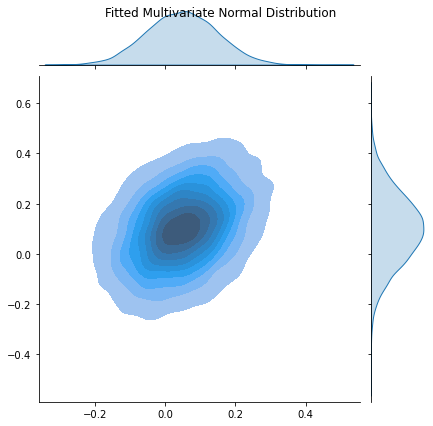

In [15]:
from numpy.linalg import inv, cholesky
import scipy.stats as stats
X1 = problem03_data["x1"]
X2 = problem03_data["x2"]
mu = problem03_data.mean().values 
print(mu)
cov_matrix = problem03_data.cov().values 
print(cov_matrix)
multivariate_normal_fit = stats.multivariate_normal(mean=mu, cov=cov_matrix)
num_samples = 10000
samples = multivariate_normal_fit.rvs(size=num_samples)

import matplotlib.pyplot as plt
import seaborn as sns

sns.jointplot(x=samples[:,0], y=samples[:,1], kind="kde", fill=True)
plt.xlabel("X1")
plt.ylabel("X2")
plt.suptitle("Fitted Multivariate Normal Distribution")
plt.show()

In [16]:

mu1, mu2 = mu
sigma11, sigma12 = cov_matrix[0, 0], cov_matrix[0, 1]
sigma22 = cov_matrix[1, 1]

X1_given = 0.6
mu2_given_X1 = mu2 + (sigma12 / sigma11) * (X1_given - mu1)
sigma2_given_X1 = sigma22 - (sigma12**2 / sigma11)

print(f"Method 1 - Conditional Mean of X2 | X1=0.6: {mu2_given_X1}")
print(f"Method 1 - Conditional Variance of X2 | X1=0.6: {sigma2_given_X1}")



Method 1 - Conditional Mean of X2 | X1=0.6: 0.3683249958609772
Method 1 - Conditional Variance of X2 | X1=0.6: 0.01789896964508753


In [17]:
beta_1 = sigma12 / sigma11
beta_0 = mu2 - beta_1 * mu1

mu2_given_X1_ols = beta_0 + beta_1 * X1_given

sigma2_given_X1_ols = sigma22 - beta_1 * sigma12

print(f"Method 2 (OLS) - Conditional Mean of X2 | X1=0.6: {mu2_given_X1_ols}")
print(f"Method 2 (OLS) - Conditional Variance of X2 | X1=0.6: {sigma2_given_X1_ols}")


Method 2 (OLS) - Conditional Mean of X2 | X1=0.6: 0.3683249958609772
Method 2 (OLS) - Conditional Variance of X2 | X1=0.6: 0.01789896964508753


Simulated Conditional Mean of X2 | X1=0.6: 0.36737469966036296
Simulated Conditional Variance of X2 | X1=0.6: 0.017968616403230032


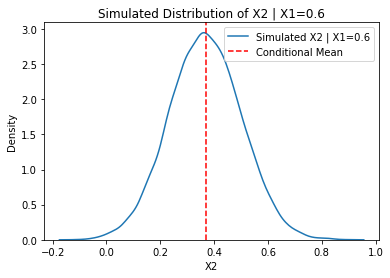

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns


L = np.linalg.cholesky(cov_matrix)

np.random.seed(100)
num_samples = 10000
Z = np.random.normal(size=(num_samples, 2))
samples = np.dot(Z, L.T) + mu
Z1 = (X1_given - mu1) / L[0, 0]
X2_simulation = mu2 + L[1, 0] * Z1 + L[1, 1] * Z[:, 1]

simulated_mean = np.mean(X2_simulation)
simulated_variance = np.var(X2_simulation)
print(f"Simulated Conditional Mean of X2 | X1=0.6: {simulated_mean}")
print(f"Simulated Conditional Variance of X2 | X1=0.6: {simulated_variance}")

sns.kdeplot(X2_simulation, label="Simulated X2 | X1=0.6")
plt.axvline(mu2_given_X1, color='r', linestyle='--', label="Conditional Mean")
plt.xlabel("X2")
plt.ylabel("Density")
plt.title("Simulated Distribution of X2 | X1=0.6")
plt.legend()
plt.show()




Q4

In [23]:
problem04_data= pd.read_csv("problem4.csv")
problem04_data

,y
0,5.050216
1,5.019310
2,5.016443
3,5.106906
4,4.993011
...,...
995,4.883588
996,4.889720
997,4.888978
998,5.072823


/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


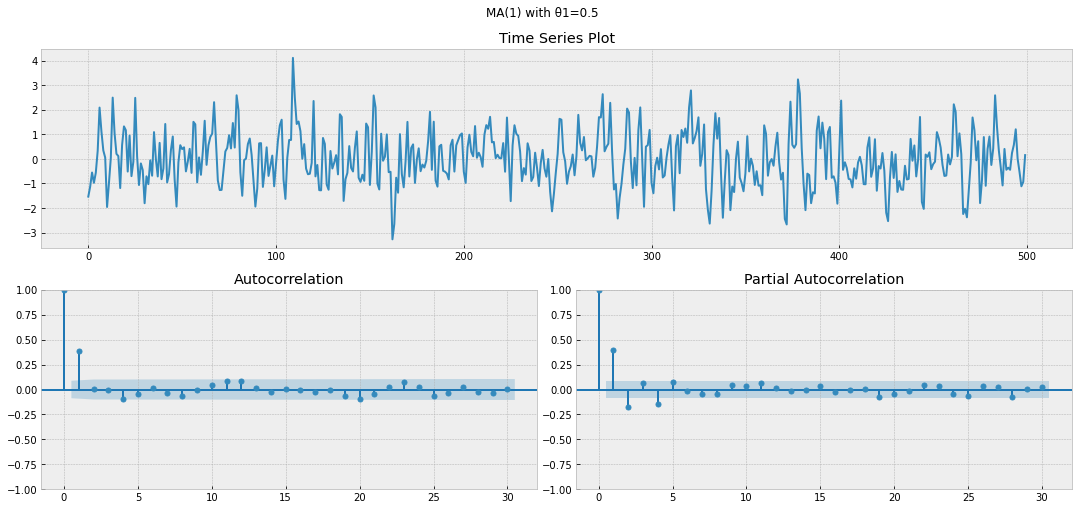

/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


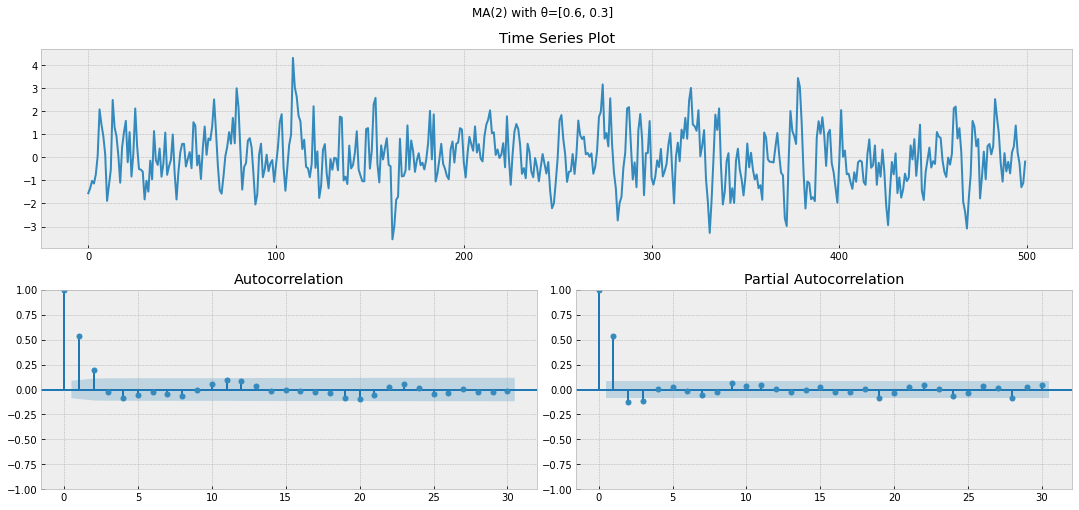

/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


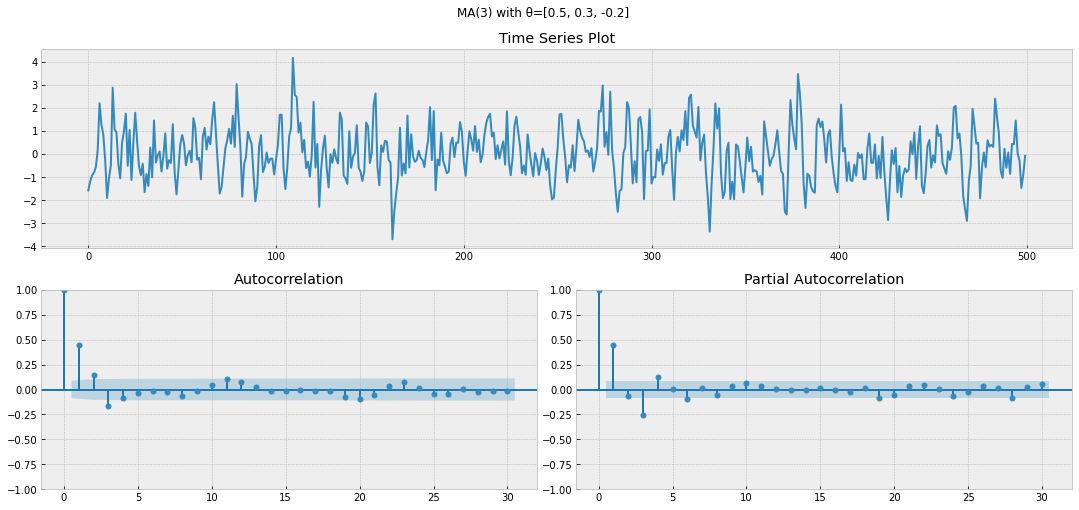

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_process import ArmaProcess
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        
        ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2) 
        acf_ax  = plt.subplot2grid(layout, (1, 0))            
        pacf_ax = plt.subplot2grid(layout, (1, 1))             
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Plot')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        plt.tight_layout()
    return


def simulate_ma_with_armaprocess(thetas, n=500, seed=42):

    np.random.seed(seed)
    ma = np.r_[1, thetas]
    ar = np.r_[1] 
    
    arma_process = ArmaProcess(ar, ma)
    X = arma_process.generate_sample(nsample=n, burnin=100)
    return X


ma1_data = simulate_ma_with_armaprocess(thetas=[0.5], n=500, seed=42)
tsplot(ma1_data, lags=30)
plt.suptitle("MA(1) with θ1=0.5", y=1.02)
plt.show()


ma2_data = simulate_ma_with_armaprocess(thetas=[0.6, 0.3], n=500, seed=42)
tsplot(ma2_data, lags=30)
plt.suptitle("MA(2) with θ=[0.6, 0.3]", y=1.02)
plt.show()


ma3_data = simulate_ma_with_armaprocess(thetas=[0.5, 0.3, -0.2], n=500, seed=42)
tsplot(ma3_data, lags=30)
plt.suptitle("MA(3) with θ=[0.5, 0.3, -0.2]", y=1.02)
plt.show()



/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


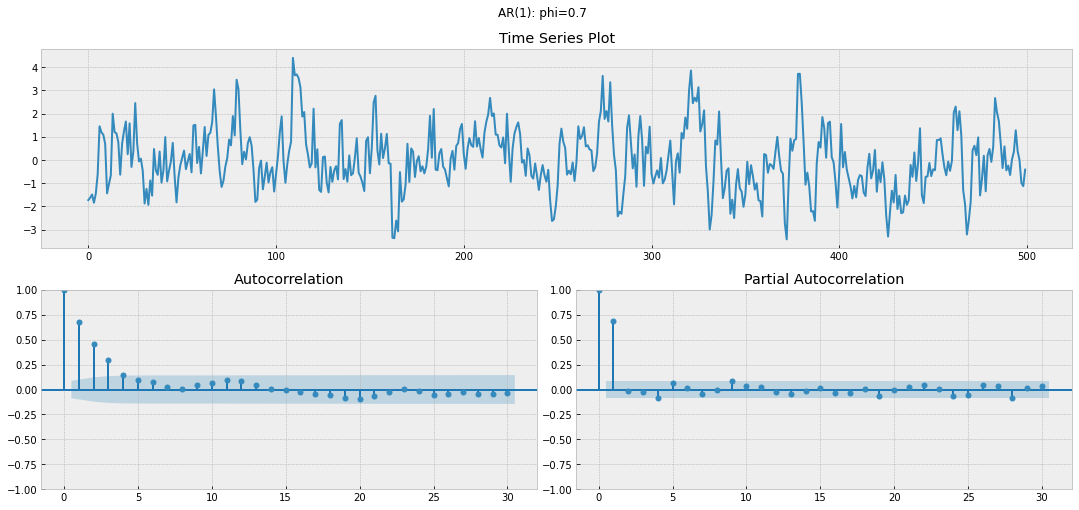

/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


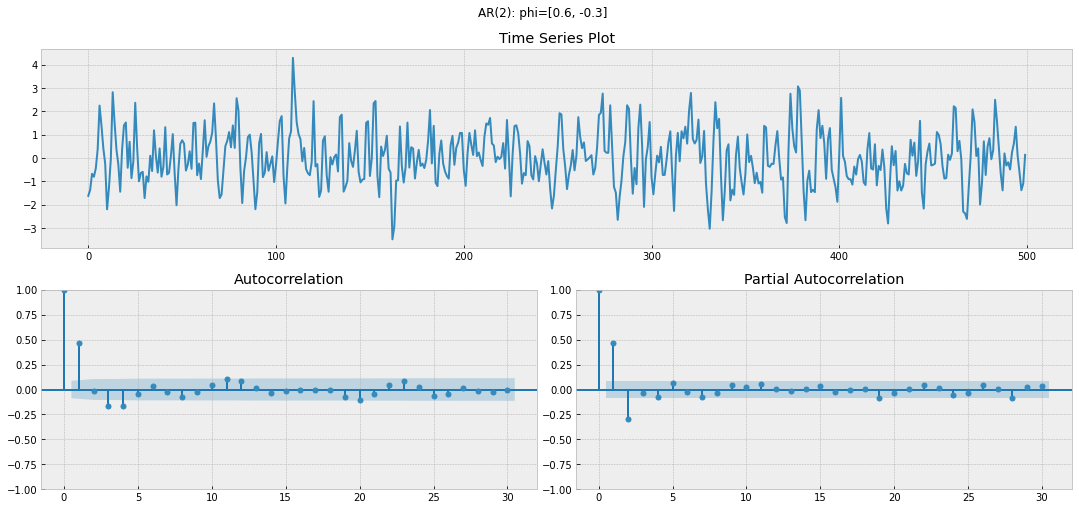

/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


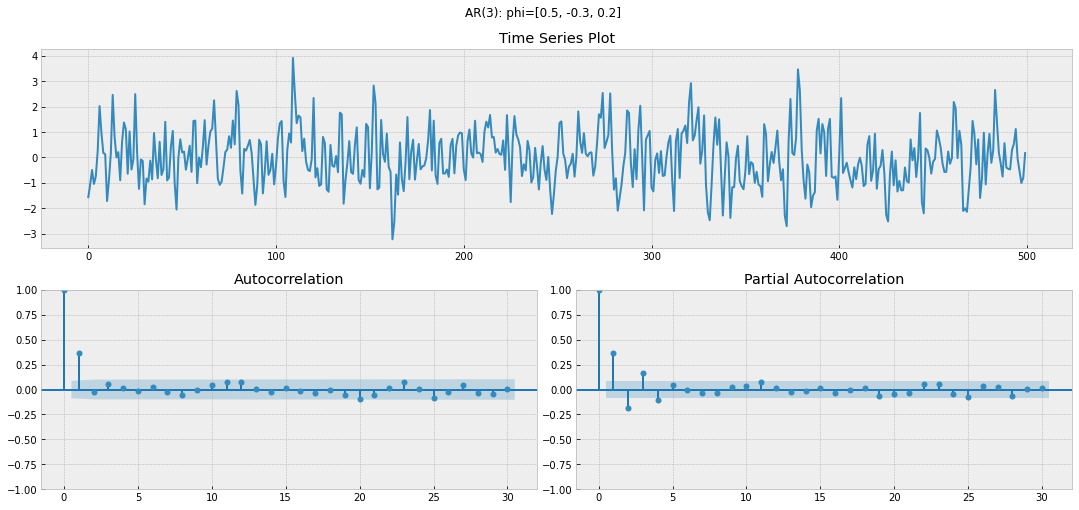

In [13]:

def simulate_ar_via_armaprocess(phis, n=500, seed=42):
    np.random.seed(seed)
    ar = np.r_[1, -np.array(phis)]
    ma = np.r_[1]
    arma_process = ArmaProcess(ar, ma)
    X = arma_process.generate_sample(nsample=n, burnin=100)
    return X

ar1_data = simulate_ar_via_armaprocess(phis=[0.7], n=500, seed=42)
tsplot(ar1_data, lags=30)
plt.suptitle("AR(1): phi=0.7", y=1.02)
plt.show()

ar2_data = simulate_ar_via_armaprocess(phis=[0.6, -0.3], n=500, seed=42)
tsplot(ar2_data, lags=30)
plt.suptitle("AR(2): phi=[0.6, -0.3]", y=1.02)
plt.show()

ar3_data = simulate_ar_via_armaprocess(phis=[0.5, -0.3, 0.2], n=500, seed=42)
tsplot(ar3_data, lags=30)
plt.suptitle("AR(3): phi=[0.5, -0.3, 0.2]", y=1.02)
plt.show()



/Users/zhaojiaxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


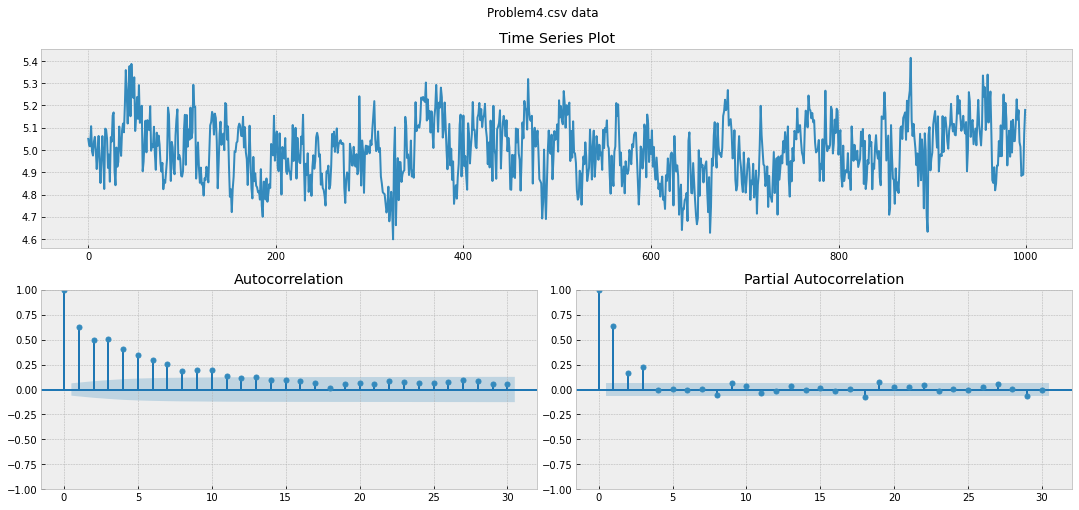

In [14]:
df = pd.read_csv("problem4.csv")  
y = df['y']
tsplot(y, lags=30)
plt.suptitle("Problem4.csv data", y=1.02)
plt.show()


In [15]:
from statsmodels.tsa.arima.model import ARIMA
def compute_aicc(aic, n, k):
    return aic + (2 * k * (k + 1)) / (n - k - 1) if n > k + 1 else np.nan 
n = len(y)
ar_vals = [1, 2, 3, 4, 5] 
ma_vals = [1, 2, 3, 4, 5] 
results = []
for p in ar_vals:
        model = ARIMA(y, order=(p, 0, 0), trend='c')  
        result = model.fit()
        k = len(result.params) 
        aic_val = result.aic
        aicc_val = compute_aicc(aic_val, n, k)

        results.append((f"AR({p})", aicc_val))
        print(f"AR({p}) - AICc: {aicc_val:.4f}")

for q in ma_vals:
    model = ARIMA(y, order=(0, 0, q), trend='c')  
    result = model.fit()
    k = len(result.params)
    aic_val = result.aic
    aicc_val = compute_aicc(aic_val, n, k)
    results.append((f"MA({q})", aicc_val))
    print(f"MA({q}) - AICc: {aicc_val:.4f}")

aicc_df = pd.DataFrame(results, columns=['Model', 'AICc'])
best_model = aicc_df.loc[aicc_df['AICc'].idxmin()]
print(f"\nBest model: {best_model['Model']} with AICc = {best_model['AICc']:.4f}")



AR(1) - AICc: -1669.0652
AR(2) - AICc: -1696.0515
AR(3) - AICc: -1746.2214
AR(4) - AICc: -1744.2235
AR(5) - AICc: -1742.2490
MA(1) - AICc: -1508.9029
MA(2) - AICc: -1559.2107
MA(3) - AICc: -1645.0726
MA(4) - AICc: -1677.5000
MA(5) - AICc: -1703.1439

Best model: AR(3) with AICc = -1746.2214


Q5

In [19]:
import numpy as np
import pandas as pd

df = pd.read_csv("DailyReturn.csv")  
df


,Date,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
0,2023-01-04,0.007720,0.010314,0.030318,-0.043743,-0.007924,0.021084,-0.011670,0.012214,0.051249,...,0.036001,0.019460,0.034628,0.016442,-0.002157,0.030420,0.076037,0.037892,0.019696,0.026626
1,2023-01-05,-0.011413,-0.010605,-0.032816,-0.029638,-0.023726,-0.003376,-0.021344,-0.009318,-0.029039,...,-0.000287,-0.018143,-0.011609,-0.003743,0.001196,-0.014553,0.009410,-0.035140,-0.012782,-0.028714
2,2023-01-06,0.022932,0.036794,0.041640,0.011785,0.035611,0.024263,0.013225,0.060196,0.024651,...,0.021641,0.029012,0.010371,0.023707,-0.008028,0.016456,0.037653,0.033673,0.067640,0.020163
3,2023-01-09,-0.000567,0.004089,0.051753,0.009736,0.014870,-0.004230,0.007786,-0.019612,0.059349,...,-0.018277,-0.003334,-0.041059,-0.023377,-0.030111,0.030303,-0.007222,-0.005058,0.016080,0.010713
4,2023-01-10,0.007013,0.004456,0.017981,0.007617,0.028732,0.027188,0.004544,-0.003398,-0.007681,...,0.012030,0.000000,0.017410,0.005637,0.007190,0.009871,0.015082,-0.000086,0.013660,0.020539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2024-12-27,-0.010527,-0.013242,-0.020868,-0.017302,-0.014534,-0.005867,-0.014519,-0.014713,-0.049479,...,0.004246,-0.003408,-0.010539,-0.002120,-0.002061,-0.017440,-0.013249,-0.015436,-0.007974,-0.006042
499,2024-12-30,-0.011412,-0.013263,0.003503,-0.013240,-0.010950,-0.014288,-0.007885,-0.025522,-0.033012,...,-0.018103,-0.006980,-0.013996,-0.008175,-0.011453,-0.009809,-0.036209,-0.001330,-0.017030,-0.007139
500,2024-12-31,-0.003638,-0.007058,-0.023275,-0.007838,-0.008631,-0.009691,-0.010144,-0.015876,-0.032510,...,0.007397,0.002029,0.003391,0.003231,0.005317,-0.003235,-0.013480,0.005709,0.001109,0.007436
501,2025-01-02,-0.002457,-0.026236,0.029935,-0.006928,0.003783,0.023450,0.000687,0.000604,-0.060816,...,0.010082,-0.005037,0.004256,-0.013681,-0.007594,0.008654,0.037666,-0.013623,0.002907,0.001421


In [20]:
import pandas as pd 
import numpy as np

def calculate_ewcov(returns_df, lambda_param=0.97):
    if 'Date' in returns_df.columns:
        returns_df = returns_df.set_index('Date')
    
    T = len(returns_df)
    N = len(returns_df.columns)
    
    weights = np.array([lambda_param ** i for i in range(T-1, -1, -1)])
    weights = weights / np.sum(weights) 
    weighted_means = np.sum(returns_df.values * weights.reshape(-1, 1), axis=0)
    cov_matrix = np.zeros((N, N))
    demeaned_returns = returns_df.values - weighted_means
    
    for i in range(N):
        for j in range(i, N):
            cov = np.sum(weights * demeaned_returns[:, i] * demeaned_returns[:, j])
            cov_matrix[i, j] = cov
            cov_matrix[j, i] = cov  
    
    return pd.DataFrame(
        cov_matrix,
        index=returns_df.columns,
        columns=returns_df.columns
    )
    
df = pd.read_csv('DailyReturn.csv')
ewcov_matrix = calculate_ewcov(df)
print(ewcov_matrix)


           SPY      AAPL      NVDA      MSFT      AMZN      META     GOOGL  \
SPY   0.000072  0.000054  0.000124  0.000080  0.000112  0.000081  0.000088   
AAPL  0.000054  0.000139  0.000041  0.000084  0.000081  0.000056  0.000071   
NVDA  0.000124  0.000041  0.000663  0.000133  0.000196  0.000186  0.000145   
MSFT  0.000080  0.000084  0.000133  0.000161  0.000174  0.000126  0.000122   
AMZN  0.000112  0.000081  0.000196  0.000174  0.000323  0.000188  0.000201   
...        ...       ...       ...       ...       ...       ...       ...   
KKR   0.000135  0.000041  0.000220  0.000105  0.000188  0.000119  0.000161   
MU    0.000148  0.000055  0.000304  0.000151  0.000173  0.000165  0.000167   
PLD   0.000059  0.000060  0.000014  0.000061  0.000057  0.000014  0.000025   
LRCX  0.000127  0.000084  0.000322  0.000152  0.000185  0.000229  0.000158   
EQIX  0.000053  0.000038  0.000050  0.000054  0.000071  0.000074  0.000051   

          AVGO      TSLA      GOOG  ...      SBUX       MMC    

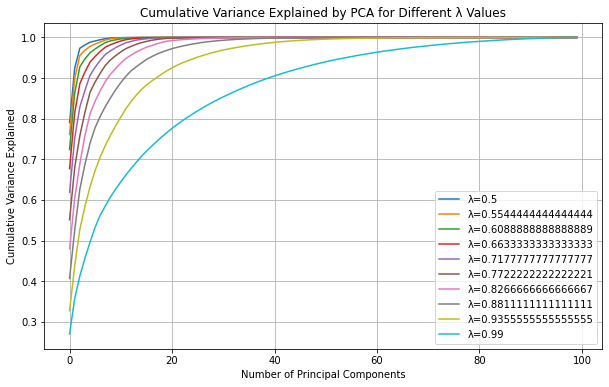

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cumulative_variance(data, decay):
    cov_matrix = calculate_ewcov(data, decay)
    eigen_vals, _ = np.linalg.eigh(cov_matrix)

    eigen_vals = np.clip(eigen_vals, a_min=0, a_max=None)
    sorted_eigen_vals = np.sort(eigen_vals)[::-1]
    cumulative_var = np.cumsum(sorted_eigen_vals) / np.sum(sorted_eigen_vals)
    return cumulative_var

def plot_cumulative_variance(data, decay_factors):
    plt.figure(figsize=(10, 6))
    for decay in decay_factors:
        cumulative_var = compute_cumulative_variance(data, decay)
        plt.plot(cumulative_var, label=f'λ={decay}')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained by PCA for Different λ Values')
    plt.legend()
    plt.grid(True)
    plt.show()

lambda_list = np.linspace(0.50, 0.99, 10)
plot_cumulative_variance(df, lambda_list)




Question 6

In [55]:
problem6_data = pd.read_csv("problem6.csv")
problem6_data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,x500
0,0.005315,0.000215,-0.000777,0.000418,-0.000687,0.000166,0.000935,-0.000445,0.000826,0.000146,...,0.001210,-0.000365,0.000155,-0.000881,-0.000284,-0.000149,0.000021,0.000237,0.001169,-0.000095
1,0.000215,0.001781,0.000094,-0.000109,-0.000438,0.000523,-0.000803,0.000242,0.000596,0.000129,...,0.000212,0.000256,-0.000106,-0.000080,0.000053,-0.000190,0.000009,0.000370,0.000707,0.000139
2,-0.000777,0.000094,0.004925,0.000320,-0.000592,0.000418,-0.000195,0.000543,0.001143,-0.000326,...,-0.000634,-0.000883,-0.000068,-0.000492,0.000222,-0.000761,-0.000269,-0.000335,0.000360,-0.000124
3,0.000418,-0.000109,0.000320,0.002545,-0.000323,-0.000106,0.000165,-0.000077,-0.000186,-0.000830,...,-0.000069,-0.000187,-0.000157,-0.000183,-0.000380,0.000310,0.000172,0.000148,0.000761,0.000240
4,-0.000687,-0.000438,-0.000592,-0.000323,0.009133,-0.001379,-0.002163,-0.000677,-0.000217,0.000413,...,0.001167,0.000394,-0.000137,0.000604,-0.000234,0.001203,0.000028,0.000201,-0.001461,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.000149,-0.000190,-0.000761,0.000310,0.001203,-0.000321,-0.000407,-0.000912,0.000609,0.000849,...,0.000940,-0.000986,-0.000787,-0.000047,-0.000178,0.008432,-0.000725,-0.000198,0.000197,-0.000221
496,0.000021,0.000009,-0.000269,0.000172,0.000028,-0.000077,-0.000186,-0.000232,-0.000394,-0.000022,...,0.000024,0.000218,0.000197,-0.000057,-0.000052,-0.000725,0.001514,0.000496,0.000397,-0.000023
497,0.000237,0.000370,-0.000335,0.000148,0.000201,-0.000211,0.000027,0.000181,0.000187,0.000257,...,0.000234,0.000097,0.000087,-0.000255,-0.000015,-0.000198,0.000496,0.002112,-0.000009,0.000150
498,0.001169,0.000707,0.000360,0.000761,-0.001461,-0.000144,-0.000473,0.000275,0.000231,-0.000506,...,-0.000674,0.000503,-0.000002,-0.000462,-0.000184,0.000197,0.000397,-0.000009,0.005130,0.000180


In [57]:
#problem 6_1
import numpy as np
import pandas as pd
import time

np.random.seed(42)
df_cov = pd.read_csv("problem6.csv", header=0)
cov_matrix6 = df_cov.to_numpy()
def is_positive_semidefinite(cov_matrix,tolerance=1e-8):
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    print(eigenvalues)   
    for i in range(len(eigenvalues)):
        if eigenvalues[i] >=tolerance:
            continue
        else:
            print(f"covariance matrix is not  at least positive semi-definite, {eigenvalues[i]}")
is_positive_semidefinite(cov_matrix6)


[-5.40255311e-12 -1.77811746e-12 -7.81594626e-13 -7.65731933e-13
 -7.33180079e-13 -7.27622006e-13 -6.77015621e-13 -6.68152191e-13
 -6.64440070e-13 -6.27519725e-13 -6.22246658e-13 -6.10392472e-13
 -5.94790124e-13 -5.80594474e-13 -5.61413317e-13 -5.39013425e-13
 -5.34750096e-13 -5.24365497e-13 -5.17273501e-13 -5.12827470e-13
 -5.11473913e-13 -5.04491318e-13 -4.91896159e-13 -4.89386268e-13
 -4.83728273e-13 -4.73674998e-13 -4.72341382e-13 -4.67888290e-13
 -4.65192940e-13 -4.54143983e-13 -4.50443323e-13 -4.48781789e-13
 -4.40372623e-13 -4.38536899e-13 -4.35504275e-13 -4.28980430e-13
 -4.23554609e-13 -4.22094980e-13 -4.17567936e-13 -4.12445742e-13
 -4.07227067e-13 -4.02972512e-13 -4.00266955e-13 -3.96653879e-13
 -3.94644140e-13 -3.93294941e-13 -3.88306203e-13 -3.85056329e-13
 -3.82000645e-13 -3.78457286e-13 -3.71443738e-13 -3.70184326e-13
 -3.68260458e-13 -3.62044259e-13 -3.61099025e-13 -3.58432697e-13
 -3.54551684e-13 -3.51251263e-13 -3.47526312e-13 -3.42074797e-13
 -3.40796463e-13 -3.35081

In [58]:
cov_mat_raw_df = pd.DataFrame(cov_matrix6)
cov_mat = Higham(cov_mat_raw_df)
cov_mat

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.005315,0.000215,-0.000777,0.000418,-0.000687,0.000166,0.000935,-0.000445,0.000826,0.000146,...,0.001210,-0.000365,0.000155,-0.000881,-0.000284,-0.000149,0.000021,0.000237,0.001169,-0.000095
1,0.000215,0.001781,0.000094,-0.000109,-0.000438,0.000523,-0.000803,0.000242,0.000596,0.000129,...,0.000212,0.000256,-0.000106,-0.000080,0.000053,-0.000190,0.000009,0.000370,0.000707,0.000139
2,-0.000777,0.000094,0.004925,0.000320,-0.000592,0.000418,-0.000195,0.000543,0.001143,-0.000326,...,-0.000634,-0.000883,-0.000068,-0.000492,0.000222,-0.000761,-0.000269,-0.000335,0.000360,-0.000124
3,0.000418,-0.000109,0.000320,0.002545,-0.000323,-0.000106,0.000165,-0.000077,-0.000186,-0.000830,...,-0.000069,-0.000187,-0.000157,-0.000183,-0.000380,0.000310,0.000172,0.000148,0.000761,0.000240
4,-0.000687,-0.000438,-0.000592,-0.000323,0.009133,-0.001379,-0.002163,-0.000677,-0.000217,0.000413,...,0.001167,0.000394,-0.000137,0.000604,-0.000234,0.001203,0.000028,0.000201,-0.001461,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.000149,-0.000190,-0.000761,0.000310,0.001203,-0.000321,-0.000407,-0.000912,0.000609,0.000849,...,0.000940,-0.000986,-0.000787,-0.000047,-0.000178,0.008432,-0.000725,-0.000198,0.000197,-0.000221
496,0.000021,0.000009,-0.000269,0.000172,0.000028,-0.000077,-0.000186,-0.000232,-0.000394,-0.000022,...,0.000024,0.000218,0.000197,-0.000057,-0.000052,-0.000725,0.001514,0.000496,0.000397,-0.000023
497,0.000237,0.000370,-0.000335,0.000148,0.000201,-0.000211,0.000027,0.000181,0.000187,0.000257,...,0.000234,0.000097,0.000087,-0.000255,-0.000015,-0.000198,0.000496,0.002112,-0.000009,0.000150
498,0.001169,0.000707,0.000360,0.000761,-0.001461,-0.000144,-0.000473,0.000275,0.000231,-0.000506,...,-0.000674,0.000503,-0.000002,-0.000462,-0.000184,0.000197,0.000397,-0.000009,0.005130,0.000180


In [59]:
def chol_psd(matrix):
    if isinstance(matrix, pd.DataFrame):
        matrix = matrix.to_numpy()
    matrix = np.asarray(matrix, dtype=float)
    
    size = matrix.shape[0]
    cholesky_root = np.zeros_like(matrix, dtype=float)
    
    for j in range(size):
        sum_squares = np.dot(cholesky_root[j, :j], cholesky_root[j, :j]) if j > 0 else 0.0
        diagonal_element = matrix[j, j] - sum_squares
        if abs(diagonal_element) < 1e-10:
            diagonal_element = 0.0
        
        cholesky_root[j, j] = np.sqrt(max(diagonal_element, 0.0))
        
        if cholesky_root[j, j] > 0.0:
            inv_cholesky_jj = 1.0 / cholesky_root[j, j]
            for i in range(j + 1, size):
                cholesky_root[i, j] = (matrix[i, j] - np.dot(cholesky_root[i, :j], cholesky_root[j, :j])) * inv_cholesky_jj

    return cholesky_root


In [49]:
# (A) Cholesky
n_samples = 10000
np.random.seed(42)
start_chol = time.time()
root =chol_psd(cov_mat)
def simulate_draws(root, num_draws=10_000):
    n = root.shape[0] 
    Z = np.random.randn(n, num_draws)
    X = root @ Z 
    return X.T  
num_draws = 10_000
simulated_samples = simulate_draws(root, num_draws)
chol_time = time.time() - start_chol

simulated_samples



array([[ 0.03621333, -0.02710305,  0.01681512, ...,  0.10041235,
         0.07621382, -0.03372163],
       [-0.01008027, -0.01326968,  0.02019511, ..., -0.0054309 ,
        -0.06949223,  0.00756366],
       [ 0.04722023, -0.02324316, -0.0735852 , ..., -0.02567093,
        -0.00090716, -0.03584797],
       ...,
       [-0.05142166,  0.01385176, -0.02609586, ..., -0.01701678,
         0.06546938,  0.02422374],
       [ 0.03614417,  0.07360471, -0.13130306, ...,  0.01805894,
         0.08809854,  0.06189746],
       [ 0.04697964, -0.06630447, -0.02756588, ...,  0.02937415,
        -0.01457181, -0.03632474]])

In [60]:
# (B) PCA 75% 
np.random.seed(42)
def pca(cov_matrix, var_threshold=0.75):
    vals, vecs = np.linalg.eigh(cov_matrix)
    idx_desc = np.argsort(vals)[::-1]
    vals_desc, vecs_desc = vals[idx_desc], vecs[:, idx_desc]
    
    k = np.searchsorted(np.cumsum(vals_desc) / np.sum(vals_desc), var_threshold) + 1
    return k, vals_desc[:k], vecs_desc[:, :k]

start_pca = time.time()
k, top_vals, top_vecs = pca(cov_mat, var_threshold=0.75)
X_pca = (np.random.randn(n_samples, k) * np.sqrt(top_vals)) @ top_vecs.T
pca_time = time.time() - start_pca
X_pca

array([[-0.03466992, -0.02854537,  0.10989113, ..., -0.03606789,
         0.01899417,  0.01054166],
       [ 0.05850373,  0.01994475, -0.0191151 , ..., -0.02376164,
         0.06550958,  0.01434629],
       [ 0.01968685,  0.03171601, -0.11676016, ...,  0.06842534,
         0.00870137, -0.00081285],
       ...,
       [ 0.05869642, -0.00755656, -0.03974421, ..., -0.06242227,
         0.09066364, -0.00036537],
       [ 0.04485951, -0.01341438,  0.03094464, ..., -0.03890079,
         0.06976225, -0.01744394],
       [-0.19486694, -0.0401917 , -0.01255604, ..., -0.01990453,
        -0.04077822, -0.02108266]])

In [61]:
# (C) Frobenius norm of these matrices to the original covariance matrix.
def sample_cov(X):
    return np.cov(X, rowvar=False)

fro_diff_chol = np.linalg.norm(cov_matrix6 - sample_cov(simulated_samples), ord='fro')
fro_diff_pca = np.linalg.norm(cov_matrix6 - sample_cov(X_pca), ord='fro')
print(fro_diff_chol)
print(fro_diff_pca)

0.02131020154814638
0.0831419253334547


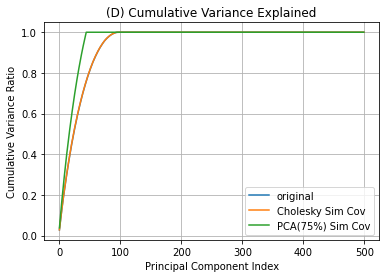

In [51]:
# (D) cumulative variance explained by each eigenvalue of the 2 simulated covariance matrices along with the input matrix.
def cumulative_variance_ratio(matrix):
    evals, _ = np.linalg.eigh(matrix)  
    evals_sorted = np.sort(evals)[::-1]  
    return np.cumsum(evals_sorted) / np.sum(evals_sorted)  


cums = [cumulative_variance_ratio(m) for m in [cov_matrix6,sample_cov(simulated_samples), sample_cov(X_pca)]]
plt.plot(cums[0], label="original")
plt.plot(cums[1], label="Cholesky Sim Cov")
plt.plot(cums[2], label="PCA(75%) Sim Cov")
plt.xlabel("Principal Component Index"), plt.ylabel("Cumulative Variance Ratio")
plt.legend(), plt.grid(), plt.title("(D) Cumulative Variance Explained")
plt.show()


In [53]:
# (E) 
print(f"(E) Time: Cholesky={chol_time:.4f}s, PCA(75%)={pca_time:.4f}s")

(E) Time: Cholesky=0.5669s, PCA(75%)=0.0831s
